# Финальный проект
**Вариант 1**

**Исполнитель:** Ивашкин Дмитрий


**Условие:**

Представьте, что вы работаете в компании, которая разрабатывает мобильные игры. К вам пришел менеджер с рядом задач по исследованию нескольких аспектов мобильного приложения:

* В первую очередь, его интересует показатель retention. Напишите функцию для его подсчета.
* Помимо этого, в компании провели A/B тестирование наборов акционных предложений. На основе имеющихся данных определите, какой набор можно считать лучшим и на основе каких метрик стоит принять правильное решение.
* Предложите метрики для оценки результатов последнего прошедшего тематического события в игре.




### Подготовка библиотек для анализа:

In [49]:
# Импорт необходимых нам библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import datetime
from datetime import date
import scipy.stats as ss
from tqdm.auto import tqdm
from scipy.stats import shapiro, mannwhitneyu, norm

# Импорт библиотек для загрузки файлов с Яндекс диска
import requests
import json
from urllib.parse import urlencode

%matplotlib inline

In [50]:
# Задаём параметры графиков:
plt.rcParams['figure.figsize'] = (16, 8)

# Задание 1: 
**1.1 Условие**

Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока). Данные лежат в папке shared и имеют следующую структуру:

* `shared/problem1-reg_data.csv` – данные о времени регистрации

|auth_ts| uid|
|------|------|
| 906166566 | 2 |
| 906344325	| 2 |
| 906686169	| 2 |
| 906893386	| 2 |
| 906980227	| 2 |



* `shared/problem1-auth_data.csv` – данные о времени захода пользователей в игру

|reg_ts | uid|
|------|------|
| 906166566	|2|
| 924422172	|3|
| 937374732	|4|
| 947425117	|5|
| 955630339	|6|

Функция должна быть написана на python. В ходе решения можно тестировать работу функции как на полном датасете, так и на части (сэмпле) данных.

## Подготовка к анализу данных

#### Загружаем данные:

In [51]:
path_auth = '/mnt/HC_Volume_18315164/home-jupyter/jupyter-d-ivashkin-23/shared/problem1-auth_data.csv'
path_reg = '/mnt/HC_Volume_18315164/home-jupyter/jupyter-d-ivashkin-23/shared/problem1-reg_data.csv'

In [52]:
# данные о времени регистрации
df_reg = pd.read_csv(path_reg, sep=';')

In [53]:
df_reg.head()

reg_ts  uid
0  911382223    1
1  932683089    2
2  947802447    3
3  959523541    4
4  969103313    5

In [54]:
# посмотрим информацию о данных
df_reg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   reg_ts  1000000 non-null  int64
 1   uid     1000000 non-null  int64
dtypes: int64(2)
memory usage: 15.3 MB


In [58]:
# суммарное количество пропусков в каждом столбце
df_reg.isna().sum()

reg_ts    0
uid       0
reg_dt    0
dtype: int64

In [59]:
# приведём время из timestamp в дату
df_reg['reg_dt'] = pd.to_datetime(
        df_reg.reg_ts, unit='s').dt.date

In [60]:
# данные о времени регистрации
df_auth = pd.read_csv(path_auth, sep=';')

In [61]:
df_auth.head()

auth_ts  uid
0  911382223    1
1  932683089    2
2  932921206    2
3  933393015    2
4  933875379    2

In [62]:
# посмотрим информацию о данных
df_auth.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9601013 entries, 0 to 9601012
Data columns (total 2 columns):
 #   Column   Dtype
---  ------   -----
 0   auth_ts  int64
 1   uid      int64
dtypes: int64(2)
memory usage: 146.5 MB


In [63]:
# суммарное количество пропусков в каждом столбце
df_auth.isna().sum()

auth_ts    0
uid        0
dtype: int64

In [64]:
# приведём время из timestamp в дату
df_auth['auth_dt'] = pd.to_datetime(
        df_auth.auth_ts, unit='s').dt.date

#### Объединим данные:

In [80]:
full_df = df_reg.merge(df_auth, on='uid')
# посчитаем разницу дат между регистрацией пользователя и заходом в игру
full_df['timedelta'] = (full_df.auth_dt - 
                            full_df.reg_dt).dt.days

In [81]:
# посмотрим минимальные даты:
full_df[['reg_dt', 'auth_dt']].min()

reg_dt     1998-11-18
auth_dt    1998-11-18
dtype: object

In [82]:
# посмотрим максимальные даты:
full_df[['reg_dt', 'auth_dt']].max()

reg_dt     2020-09-23
auth_dt    2020-09-23
dtype: object

In [90]:
# Задаём период анализа:
start_date = datetime.date(2020, 1, 1)
end_date = datetime.date(2020, 2, 1)

In [91]:
# Создадим датафрейм с заданным периодом анализа:
full_df_dt = full_df.query(
        'reg_dt >= @start_date and auth_dt <= @end_date')

In [92]:
# Создадим таблицу для когортного анализа, за когорты будем считать день регистрации пользователя:
cohort = (
        full_df_dt.groupby(['reg_dt','timedelta'], 
                        as_index=False)
          .agg({'uid':'nunique'})
          .pivot(index='reg_dt', 
                 columns='timedelta', 
                 values='uid')
    )
cohort

timedelta       0     1     2     3     4     5     6     7     8     9   ...  \
reg_dt                                                                    ...   
2020-01-01  1061.0  28.0  48.0  36.0  60.0  62.0  80.0  53.0  47.0  47.0  ...   
2020-01-02  1063.0  25.0  48.0  55.0  51.0  62.0  82.0  63.0  60.0  56.0  ...   
2020-01-03  1065.0  25.0  36.0  47.0  48.0  73.0  80.0  58.0  48.0  45.0  ...   
2020-01-04  1067.0  16.0  48.0  54.0  57.0  61.0  75.0  58.0  45.0  52.0  ...   
2020-01-05  1069.0  21.0  48.0  49.0  47.0  51.0  84.0  56.0  42.0  58.0  ...   
2020-01-06  1070.0  31.0  48.0  53.0  41.0  50.0  71.0  63.0  56.0  54.0  ...   
2020-01-07  1072.0  20.0  52.0  47.0  69.0  54.0  91.0  55.0  61.0  57.0  ...   
2020-01-08  1074.0  24.0  43.0  46.0  55.0  54.0  91.0  54.0  48.0  67.0  ...   
2020-01-09  1076.0  20.0  43.0  59.0  48.0  65.0  72.0  61.0  55.0  51.0  ...   
2020-01-10  1077.0  21.0  40.0  55.0  46.0  64.0  76.0  60.0  49.0  52.0  ...   
2020-01-11  1079.0  17.0  42.0  55.0  54.0  52.0  69.0  62.0  47.0  57.0  ...   
2020-01-12  1081.0  20.0  49.0  44.0  61.0  76.0  64.0  52.0  55.0  60.0  ...   
2020-01-13  1083.0  21.0  48.0  52.0  62.0  62.0  75.0  68.0  32.0  75.0  ...   
2020-01-14  1084.0  18.0  49.0  59.0  70.0  61.0  71.0  68.0  78.0  44.0  ...   
2020-01-15  1086.0  17.0  46.0  61.0  62.0  51.0  64.0  79.0  56.0  54.0  ...   
2020-01-16  1089.0  25.0  45.0  52.0  63.0  67.0  76.0  64.0  47.0  63.0  ...   
2020-01-17  1089.0  22.0  38.0  43.0  53.0  52.0  70.0  53.0  56.0  43.0  ...   
2020-01-18  1092.0  34.0  46.0  51.0  56.0  72.0  81.0  76.0  50.0  39.0  ...   
2020-01-19  1093.0  30.0  41.0  47.0  52.0  65.0  75.0  48.0  52.0  64.0  ...   
2020-01-20  1096.0  18.0  42.0  55.0  69.0  71.0  78.0  70.0  52.0  64.0  ...   
2020-01-21  1097.0  32.0  37.0  60.0  62.0  55.0  71.0  67.0  50.0  58.0  ...   
2020-01-22  1099.0  20.0  36.0  52.0  54.0  58.0  75.0  55.0  49.0  44.0  ...   
2020-01-23  1100.0  18.0  42.0  43.0  56.0  68.0  88.0  67.0  54.0  54.0  ...   
2020-01-24  1103.0  20.0  47.0  51.0  51.0  58.0  69.0  60.0  55.0   NaN  ...   
2020-01-25  1104.0  20.0  46.0  48.0  55.0  52.0  79.0  61.0   NaN   NaN  ...   
2020-01-26  1106.0  17.0  49.0  67.0  66.0  77.0  62.0   NaN   NaN   NaN  ...   
2020-01-27  1108.0  19.0  39.0  52.0  60.0  57.0   NaN   NaN   NaN   NaN  ...   
2020-01-28  1110.0  27.0  49.0  57.0  72.0   NaN   NaN   NaN   NaN   NaN  ...   
2020-01-29  1111.0  24.0  45.0  47.0   NaN   NaN   NaN   NaN   NaN   NaN  ...   
2020-01-30  1114.0  22.0  47.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
2020-01-31  1115.0  17.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
2020-02-01  1117.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   

timedelta     22    23    24    25    26    27    28    29    30    31  
reg_dt                                                                  
2020-01-01  37.0  29.0  40.0  33.0  42.0  38.0  35.0  35.0  25.0  33.0  
2020-01-02  46.0  44.0  36.0  40.0  36.0  33.0  36.0  33.0  30.0   NaN  
2020-01-03  40.0  33.0  34.0  40.0  38.0  27.0  26.0  31.0   NaN   NaN  
2020-01-04  38.0  34.0  34.0  28.0  27.0  29.0  24.0   NaN   NaN   NaN  
2020-01-05  36.0  41.0  37.0  40.0  34.0  39.0   NaN   NaN   NaN   NaN  
2020-01-06  43.0  38.0  31.0  35.0  33.0   NaN   NaN   NaN   NaN   NaN  
2020-01-07  42.0  46.0  41.0  35.0   NaN   NaN   NaN   NaN   NaN   NaN  
2020-01-08  38.0  44.0  32.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2020-01-09  35.0  38.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2020-01-10  41.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2020-01-11   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2020-01-12   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2020-01-13   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2020-01-14   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2020-01-15   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2020

In [93]:
# и посчитаем retention
retention_table = cohort.div(cohort[0], axis=0)
retention_table

timedelta    0         1         2         3         4         5         6   \
reg_dt                                                                        
2020-01-01  1.0  0.026390  0.045240  0.033930  0.056550  0.058435  0.075401   
2020-01-02  1.0  0.023518  0.045155  0.051740  0.047977  0.058325  0.077140   
2020-01-03  1.0  0.023474  0.033803  0.044131  0.045070  0.068545  0.075117   
2020-01-04  1.0  0.014995  0.044986  0.050609  0.053421  0.057170  0.070291   
2020-01-05  1.0  0.019645  0.044902  0.045837  0.043966  0.047708  0.078578   
2020-01-06  1.0  0.028972  0.044860  0.049533  0.038318  0.046729  0.066355   
2020-01-07  1.0  0.018657  0.048507  0.043843  0.064366  0.050373  0.084888   
2020-01-08  1.0  0.022346  0.040037  0.042831  0.051210  0.050279  0.084730   
2020-01-09  1.0  0.018587  0.039963  0.054833  0.044610  0.060409  0.066914   
2020-01-10  1.0  0.019499  0.037140  0.051068  0.042711  0.059424  0.070566   
2020-01-11  1.0  0.015755  0.038925  0.050973  0.050046  0.048193  0.063948   
2020-01-12  1.0  0.018501  0.045328  0.040703  0.056429  0.070305  0.059204   
2020-01-13  1.0  0.019391  0.044321  0.048015  0.057248  0.057248  0.069252   
2020-01-14  1.0  0.016605  0.045203  0.054428  0.064576  0.056273  0.065498   
2020-01-15  1.0  0.015654  0.042357  0.056169  0.057090  0.046961  0.058932   
2020-01-16  1.0  0.022957  0.041322  0.047750  0.057851  0.061524  0.069789   
2020-01-17  1.0  0.020202  0.034894  0.039486  0.048669  0.047750  0.064279   
2020-01-18  1.0  0.031136  0.042125  0.046703  0.051282  0.065934  0.074176   
2020-01-19  1.0  0.027447  0.037511  0.043001  0.047575  0.059469  0.068618   
2020-01-20  1.0  0.016423  0.038321  0.050182  0.062956  0.064781  0.071168   
2020-01-21  1.0  0.029170  0.033728  0.054695  0.056518  0.050137  0.064722   
2020-01-22  1.0  0.018198  0.032757  0.047316  0.049136  0.052775  0.068244   
2020-01-23  1.0  0.016364  0.038182  0.039091  0.050909  0.061818  0.080000   
2020-01-24  1.0  0.018132  0.042611  0.046238  0.046238  0.052584  0.062557   
2020-01-25  1.0  0.018116  0.041667  0.043478  0.049819  0.047101  0.071558   
2020-01-26  1.0  0.015371  0.044304  0.060579  0.059675  0.069620  0.056058   
2020-01-27  1.0  0.017148  0.035199  0.046931  0.054152  0.051444       NaN   
2020-01-28  1.0  0.024324  0.044144  0.051351  0.064865       NaN       NaN   
2020-01-29  1.0  0.021602  0.040504  0.042304       NaN       NaN       NaN   
2020-01-30  1.0  0.019749  0.042190       NaN       NaN       NaN       NaN   
2020-01-31  1.0  0.015247       NaN       NaN       NaN       NaN       NaN   
2020-02-01  1.0       NaN       NaN       NaN       NaN       NaN       NaN   

timedelta         7         8         9   ...        22        23        24  \
reg_dt                                    ...                                 
2020-01-01  0.049953  0.044298  0.044298  ...  0.034873  0.027333  0.037700   
2020-01-02  0.059266  0.056444  0.052681  ...  0.043274  0.041392  0.033866   
2020-01-03  0.054460  0.045070  0.042254  ...  0.037559  0.030986  0.031925   
2020-01-04  0.054358  0.042174  0.048735  ...  0.035614  0.031865  0.031865   
2020-01-05  0.052385  0.039289  0.054256  ...  0.033676  0.038354  0.034612   
2020-01-06  0.058879  0.052336  0.050467  ...  0.040187  0.035514  0.028972   
2020-01-07  0.051306  0.056903  0.053172  ...  0.039179  0.042910  0.038246   
2020-01-08  0.050279  0.044693  0.062384  ...  0.035382  0.040968  0.029795   
2020-01-09  0.056691  0.051115  0.047398  ...  0.032528  0.035316       NaN   
2020-01-10  0.055710  0.045497  0.048282  ...  0.038069       NaN       NaN   
2020-01-11  0.057461  0.043559  0.052827  ...       NaN       NaN       NaN   
2020-01-12  0.048104  0.050879  0.055504  ...       NaN       NaN       NaN   
2020-01-13  0.062789  0.029548  0.069252  ...       NaN       NaN       NaN   
2020-01-14  0.062731  0.071956  0.040590  ...       NaN       NaN       NaN   
2020-01-15  0.072744  0.051565  0.049724  ...    

#### Визуализируем полученные результаты:

Text(0.5, 339.0, 'Дни')

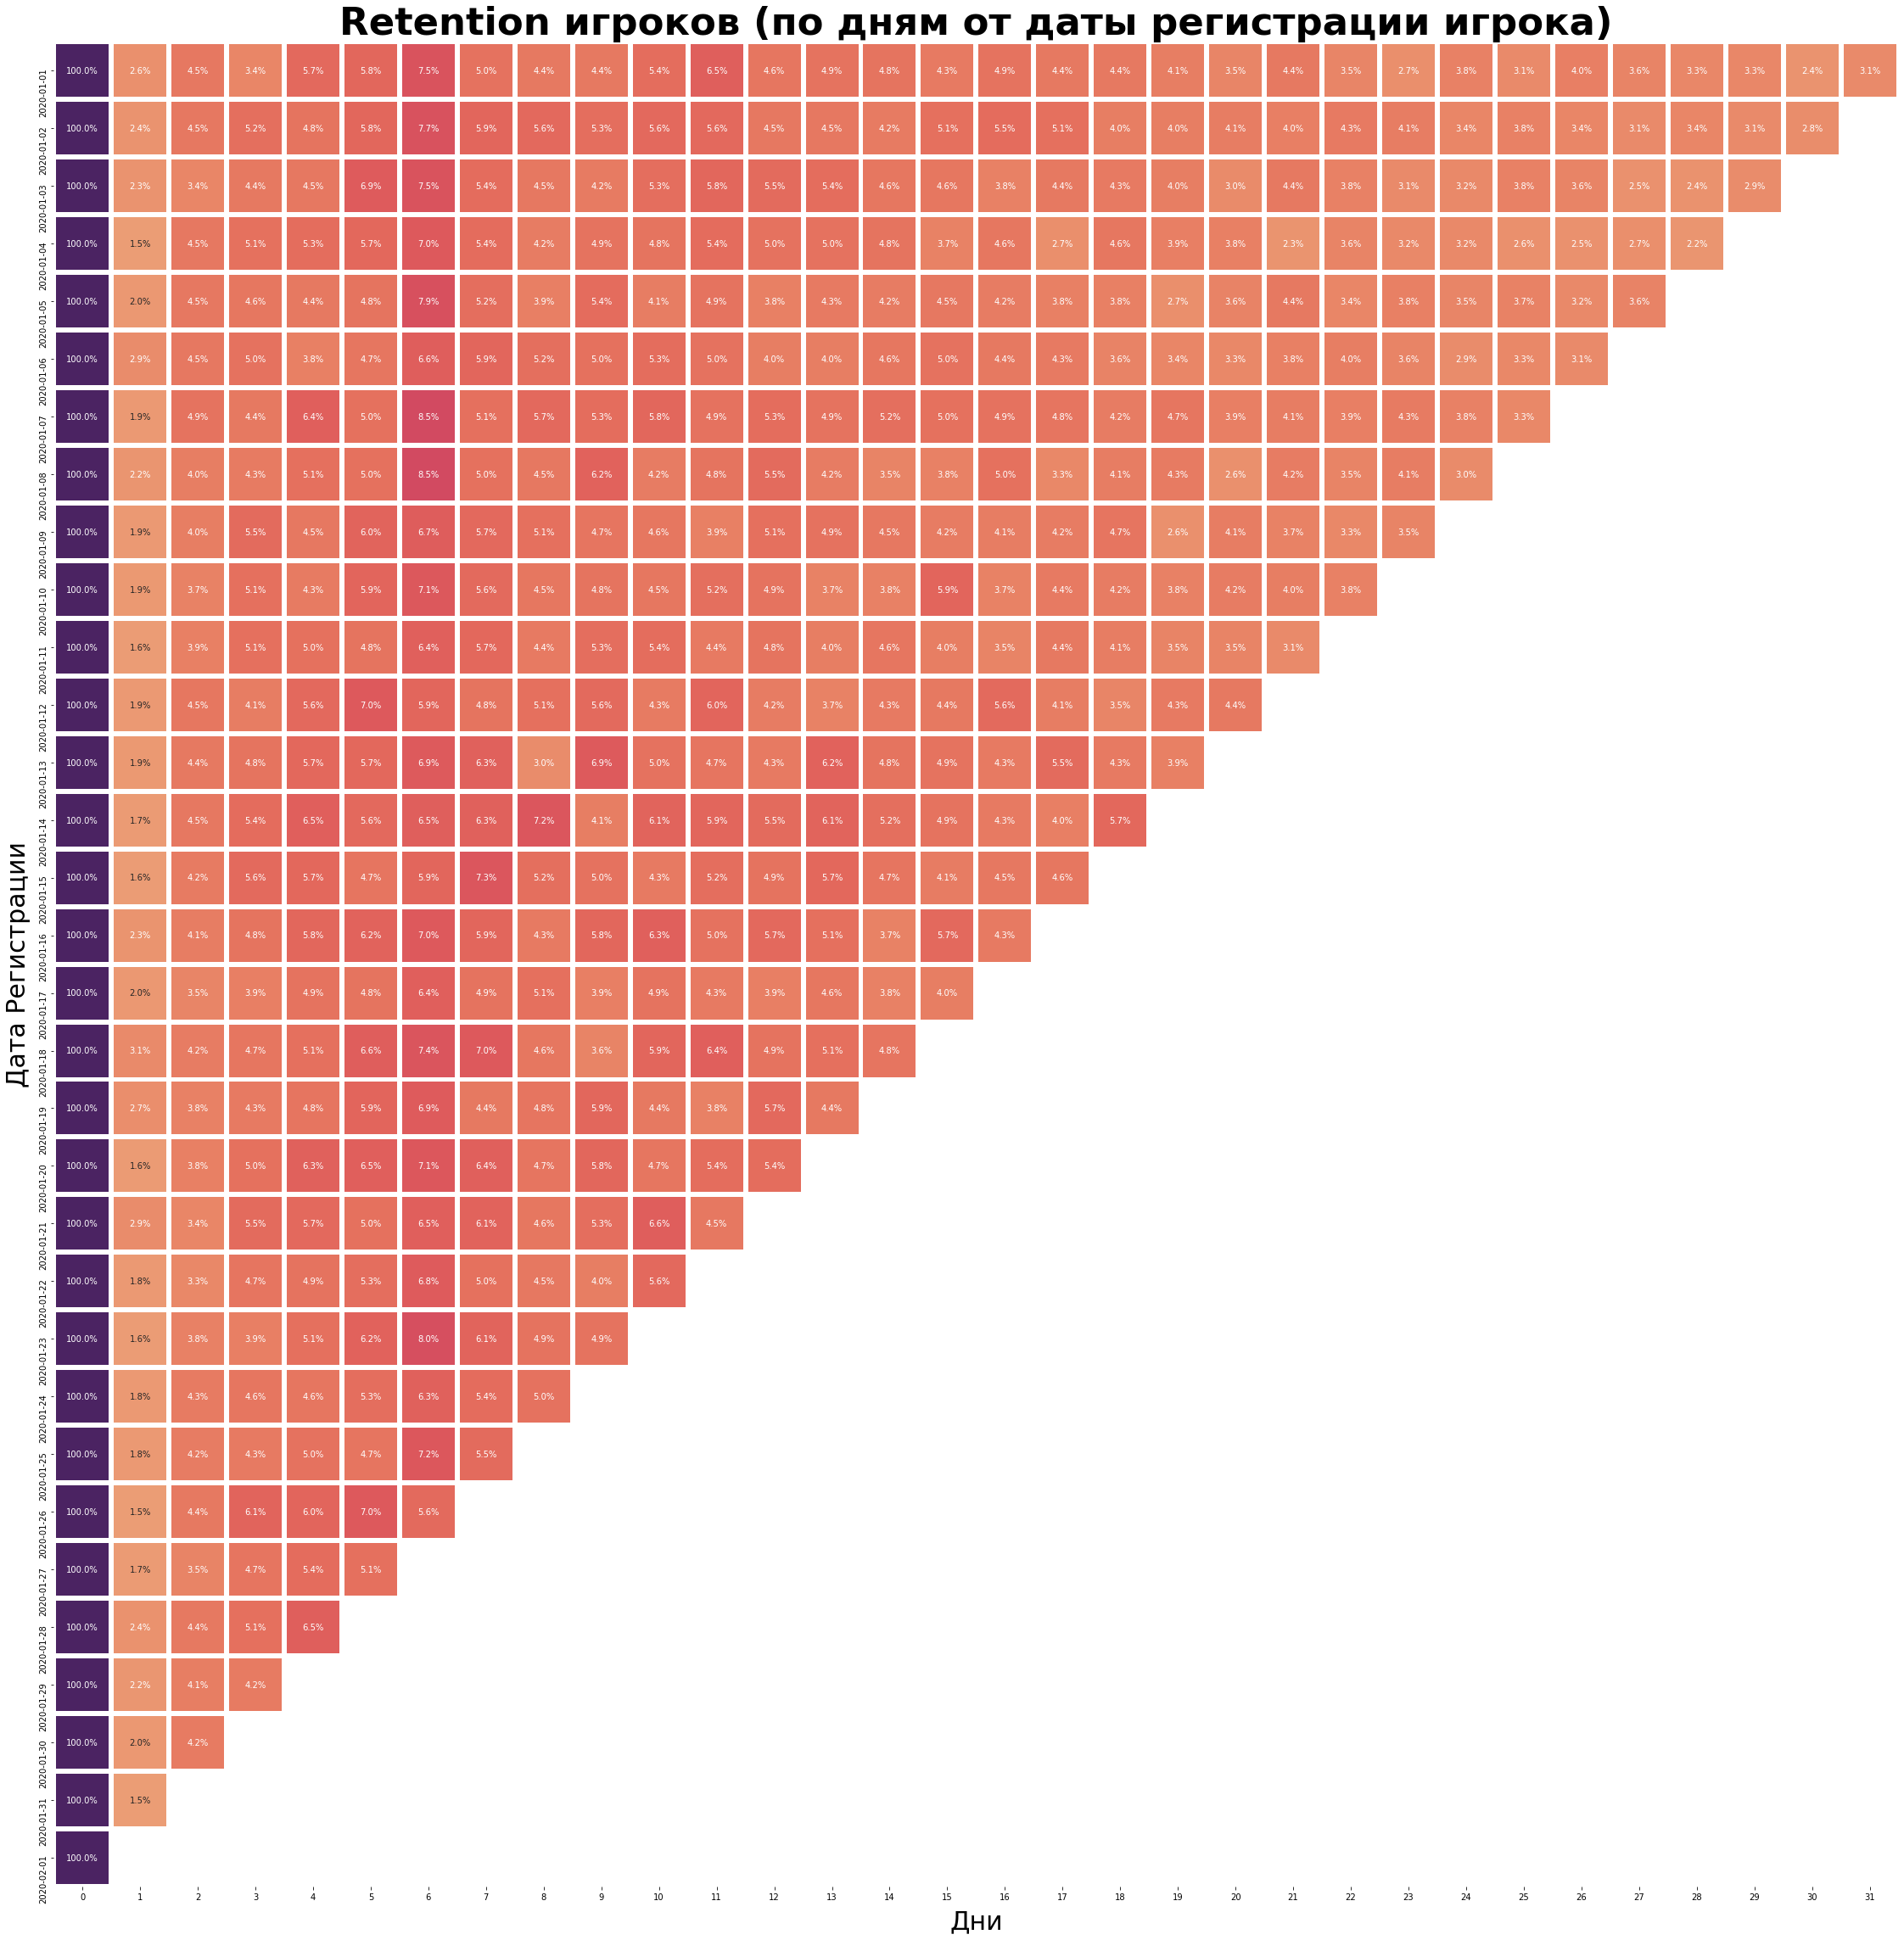

In [94]:
plt.figure(figsize=(40, 40))
plt.title('Retention игроков (по дням от даты регистрации игрока)',
              fontweight='bold', size=45)
sns.heatmap(retention_table,
                vmin=0.0,
                vmax=0.2,
                cmap='flare',
                linewidths=5,
                linecolor='white',
                fmt='.1%',
                annot=True,
                square=True,
                cbar=False)
plt.ylabel('Дата Регистрации', labelpad=10, size=30)
plt.xlabel('Дни', labelpad=10, size=30)

#### Напишем функцию:

In [182]:
def retention(df_reg, df_auth, start_date=None, end_date=None):
    """ 
    Функция подсчета Retention игроков (по дням от даты регистрации игрока)
    df_reg - датафрейм с данными о времени регистрации
    df_auth - датафрейм с данными  о времени захода пользователей в игру
    start_date - Начальный диапазон времени в формате гггг-мм-дд
    end_date - Конечный диапазон времени в формате гггг-мм-дд
    """
# Приведём время из timestamp в дату:
    df_reg['reg_dt'] = pd.to_datetime(
        df_reg.reg_ts, unit='s').dt.date
    df_auth['auth_dt'] = pd.to_datetime(
        df_auth.auth_ts, unit='s').dt.date
    
# Объединяем датафреймы и посчитаем разницу дат между регистрацией пользователя и заходом в игру:
    full_df = df_reg.merge(df_auth, on='uid')
    full_df['timedelta'] = (full_df.auth_dt - 
                            full_df.reg_dt).dt.days
    
# Период анализа:
    start_date_dt = date.fromisoformat(start_date)
    end_date_dt = date.fromisoformat(end_date)
    full_df_dt = full_df.query(
        'reg_dt >= @start_date_dt and auth_dt <= @end_date_dt')
        
# Создадим таблицу для когортного анализа, за когорты будем считать день регистрации пользователя 
# и посчитаем retention:
    cohort = (
        full_df_dt.groupby(['reg_dt','timedelta'], 
                        as_index=False)
          .agg({'uid':'nunique'})
          .pivot(index='reg_dt', 
                 columns='timedelta', 
                 values='uid')
    )
    retention_table = cohort.div(cohort[0], axis=0)
    
# Визуализируем полученные результаты:
    plt.figure(figsize=(40, 40))
    plt.title('Retention игроков (по дням от даты регистрации игрока)',
              fontweight='bold', size=45)
    sns.heatmap(retention_table,
                vmin=0.0,
                vmax=0.2,
                cmap='flare',
                linewidths=5,
                linecolor='white',
                fmt='.1%',
                annot=True,
                square=True,
                cbar=False)
    plt.ylabel('Дата Регистрации', labelpad=10, size=30)
    plt.xlabel('Дни', labelpad=10, size=30)

#### Проверим работоспособность:

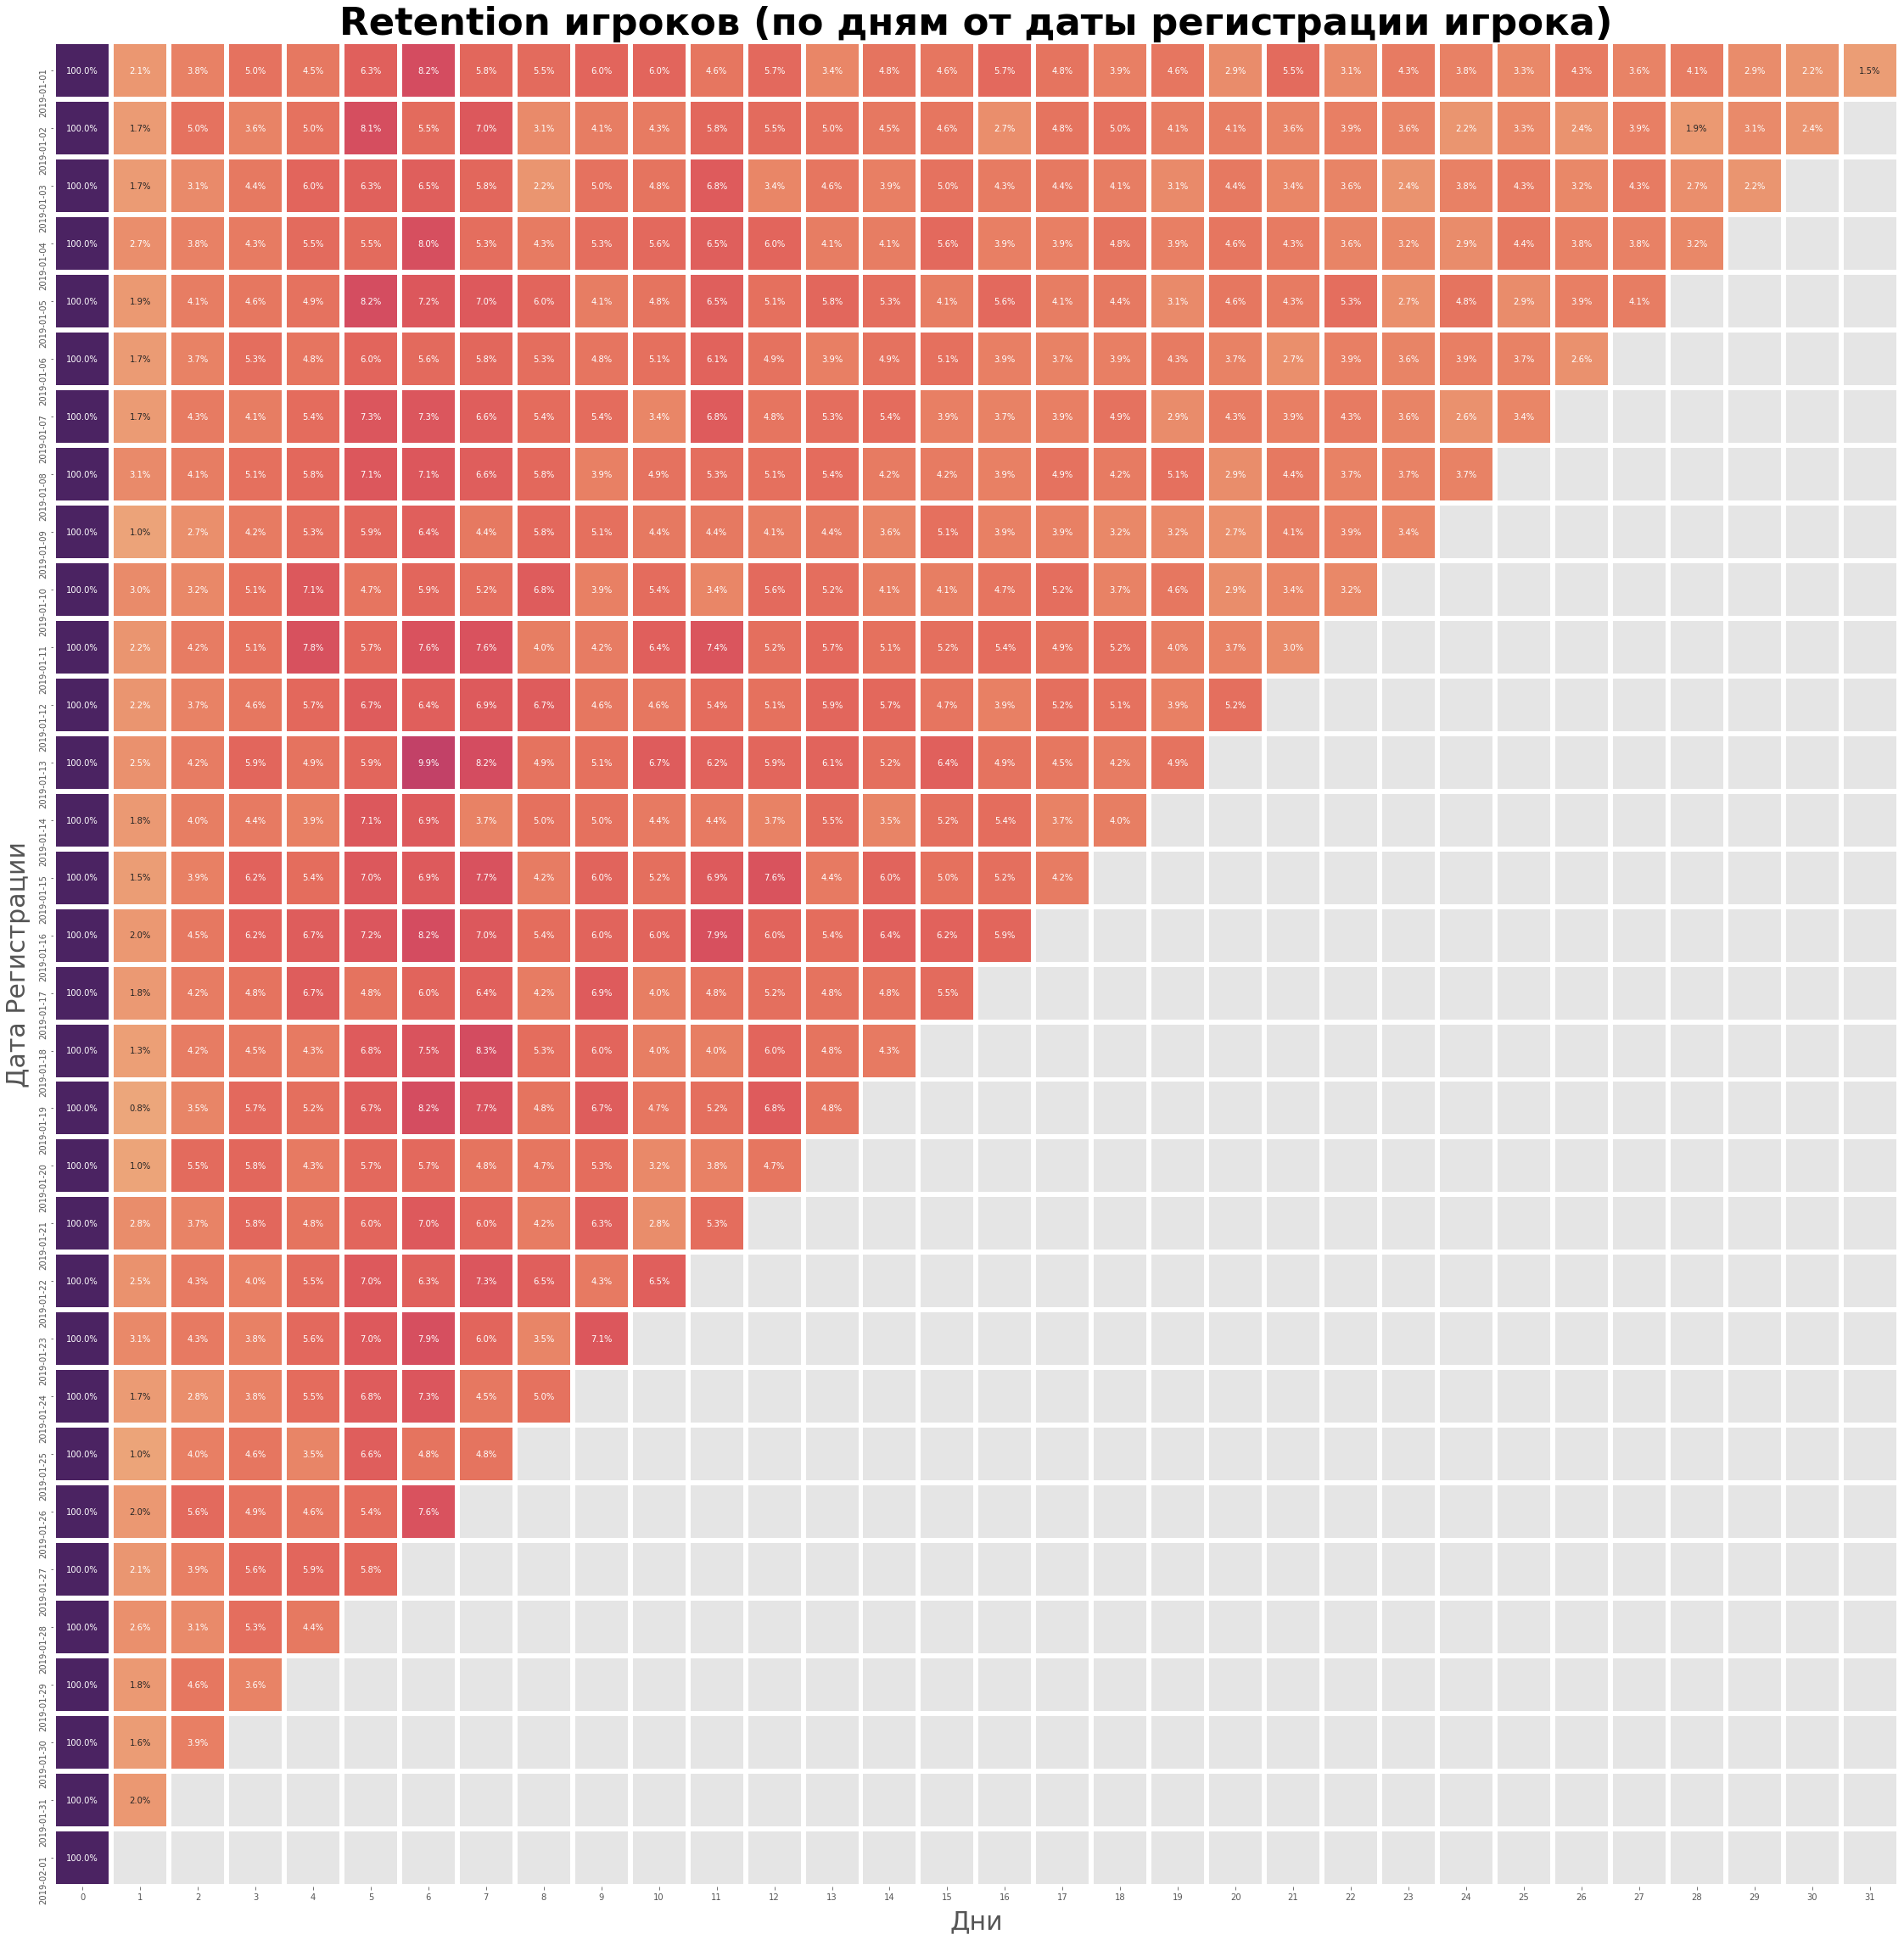

In [181]:
 retention(df_reg, df_auth, '2019-01-01', '2019-02-01')

# Задание 2: 
**2.1 Условие**

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

**2.2 Входные данные**

Формат данных:


|user_id |	revenue |	testgroup| 
|------|------|------|
    |1   | 0 |	b |
    |2   | 0 | 	a |
    |3	 | 0 |	a |
    |4	 | 0 | 	b |
    |5	 | 0 |	b |


В качестве входных данных имеем csv-файл:

* [Проект_1_Задание_2.csv](https://disk.yandex.ru/d/12gk_ATEeBZm4A)


**2.3 Вопросы**
* Какой набор предложений можно считать лучшим? 
* Какие метрики стоит проанализировать для принятия правильного решения и как?

## Загрузим данные с Яндекс.Диска:

In [99]:
YD_csv = 'https://disk.yandex.ru/d/12gk_ATEeBZm4A'

Напишем функцию загрузки CSV-файла в датафрейм:

In [100]:
def download_csv_from_YD(YD_csv_url, csv_file_sep=';'):
    """Функция для загрузки CSV файлов с Яндекс Диска и преобразования данных в датафрейм"""
    # csv_file_sep - используемый разделитель в файле CSV
    # YD_csv_url - ссылка на Я.Д

    # [API Яндекс.Диска](https://yandex.ru/dev/disk/api/reference/content.html)
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'

    # Получаем необходимую загрузочную ссылку
    full_url = base_url + urlencode(dict(public_key=YD_csv_url))
    response = requests.get(full_url)
    download_url = response.json()['href']

    # Загружаем файл и сохраняем его  в формат датафрейма
    df = pd.read_csv(download_url, sep=csv_file_sep)
    return df

In [101]:
df_2 = download_csv_from_YD(YD_csv)

#### Смотрим на данные и проводим разведывательный анализ:

In [102]:
df_2.head()

user_id  revenue testgroup
0        1        0         b
1        2        0         a
2        3        0         a
3        4        0         b
4        5        0         b

In [103]:
# посмотрим информацию о данных
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB


In [104]:
# суммарное количество пропусков в каждом столбце
df_2.isna().sum()

user_id      0
revenue      0
testgroup    0
dtype: int64

In [105]:
# посмотрим описательные статистики
df_2.describe()

user_id        revenue
count  404770.000000  404770.000000
mean   202385.500000      26.083435
std    116847.178567     681.652928
min         1.000000       0.000000
25%    101193.250000       0.000000
50%    202385.500000       0.000000
75%    303577.750000       0.000000
max    404770.000000   37433.000000

In [106]:
df_2['testgroup'].describe()

count     404770
unique         2
top            b
freq      202667
Name: testgroup, dtype: object

### Проверим разбивку значений по группам:

In [107]:
# посмотрим на разбивку по группам в датафрейме
df_2_sum = df_2 \
    .groupby('testgroup', 
          as_index=False) \
    .agg({'user_id':
          'count'}) \
    .rename(columns={'user_id': 
                     'user_numbers'})
df_2_sum['%'] = round(
    (df_2_sum.user_numbers 
     / df_2.shape[0]) * 100, 2)
df_2_sum

testgroup  user_numbers      %
0         a        202103  49.93
1         b        202667  50.07

Итого имеем:
* cуммарное количество пользователей по группам:
    * в контрольной группе А `202103` 
    * в тестовой группе  B `202667`
* % пользователей по группам: 
    * в контрольной группе А `49.93 %`
    * в тестовой группе B `50.07 %`

### Проверим количество "платящих" пользователей по группам:

In [108]:
df_2_pay = df_2[df_2.revenue > 0]
df_2_pay

user_id  revenue testgroup
72           73      351         a
160         161     3797         b
341         342      290         a
377         378     3768         b
385         386      250         a
...         ...      ...       ...
404315   404316      262         a
404525   404526     3120         b
404543   404544      369         a
404602   404603      251         a
404767   404768      231         a

[3733 rows x 3 columns]

In [109]:
df_2_pay_sum = df_2_pay \
    .groupby('testgroup', 
          as_index=False) \
    .agg({'user_id':
          'count'}) \
    .rename(columns={'user_id': 
                     'user_numbers'})
df_2_pay_sum['%'] = round(
    (df_2_pay_sum.user_numbers 
     / df_2_pay.shape[0]) * 100, 2)
df_2_pay_sum

testgroup  user_numbers      %
0         a          1928  51.65
1         b          1805  48.35

Итого имеем:
* cуммарное количество пользователей по группам:
    * в контрольной группе А `1928` 
    * в тестовой группе  B `1805`
* % пользователей по группам: 
    * в контрольной группе А `51.65 %`
    * в тестовой группе B `48.35 %`

## Поговорим о метриках:

Метрики для оценки эксперемента: ARPU, ARPPU и конверсия пользователей в платящие (CR). 

### ARPU

**Посмотрим на метрику `ARPU (средний доход на привлеченного пользователя)` по группам:**

$ARPU = \frac{Доход}{Количество \ пользователей}$ 

In [110]:
# суммарный доход платящих пользователей в контрольной группе A
control_revenue = df_2[df_2.testgroup == 'a']['revenue'].sum()
control_revenue

5136189

In [112]:
# суммарное количество пользователей в контрольной группе A
control_number_of_users = df_2_sum['user_numbers'][0]
control_number_of_users

202103

In [113]:
# суммарный доход платящих пользователей в тестовой группе B
test_revenue = df_2[df_2.testgroup == 'b']['revenue'].sum()
test_revenue

5421603

In [114]:
# суммарное количество пользователей в тестовой группе B
test_number_of_users = df_2_sum['user_numbers'][1]
test_number_of_users

202667

In [115]:
# метрика ARPU в контрольной группе A
control_ARPU = control_revenue / control_number_of_users
control_ARPU

25.413719736965806

In [116]:
# метрика ARPU в тестовой группе B
test_ARPU = test_revenue / test_number_of_users
test_ARPU

26.75128659327863

In [117]:
# отношение между метриками ARPU контрольной и тестовых групп
diff_ARPU = (control_ARPU - test_ARPU) / control_ARPU * 100
diff_ARPU

-5.263168360069894

Итого:
* ARPU (средний доход на привлеченного пользователя) по группам:
    * в контрольной группе A `25.41` 
    * в тестовой группе B `26.75`
* отношение между метриками ARPU контрольной и тестовой группы:
    * ARPU (средний доход на привлеченного пользователя) в контрольной группе меньше на `5.26 %`  чем в тестовой группе

### ARPPU

**Посмотрим на метрику `ARPPU (средний доход на платящего пользователя)` по группам:**

$ARPPU = \frac{Доход}{Количество \ пользователей, \ совершивших \ оплату}$

In [118]:
# суммарное количество платящих пользователей в контрольной группе A
control_number_of_pay_users = df_2_pay_sum['user_numbers'][0]
control_number_of_pay_users

1928

In [119]:
# суммарное количество платящих пользователей в тестовой группе B
test_number_of_pay_users = df_2_pay_sum['user_numbers'][1]
test_number_of_pay_users

1805

In [121]:
# метрика ARPPU в контрольной группе A
control_ARPPU = control_revenue / control_number_of_pay_users
control_ARPPU

2663.9984439834025

In [122]:
# метрика ARPPU в тестовой группе B
test_ARPPU = test_revenue / test_number_of_pay_users
test_ARPPU

3003.6581717451522

In [124]:
# отношение между метриками ARPPU контрольной и тестовых групп
diff_ARPPU = (control_ARPPU - test_ARPPU) / control_ARPU * 100
diff_ARPPU

-12.749997227996351

Итого:
* ARPPU (средний доход на привлеченного пользователя) по группам:
    * в контрольной группе A `2663.99` 
    * в тестовой группе B `3003.66`
* отношение между метриками ARPU контрольной и тестовой группы:
    * ARPPU (средний доход на платящего пользователя) в контрольной группе меньше на `12.75 %`  чем в тестовой группе

### CR

**Посмотрим на метрику `CR (конверсия в оплату),` по группам:**

$CR = \frac{ Количество \ пользователей, \ совершивших \ оплату }{ Количество \ пользователей} $$\times 100 $ % 

In [125]:
# метрика CR в контрольной группе A
control_CR = control_number_of_pay_users / control_number_of_users * 100
control_CR

0.9539690157988748

In [126]:
# метрика CR в тестовой группе B
test_CR = test_number_of_pay_users / test_number_of_users * 100
test_CR

0.8906235351586593

In [127]:
# отношение между метриками CR контрольной и тестовых групп
diff_CR = (control_CR - test_CR) / control_CR * 100
diff_CR

6.6402031503264904

Итого:
* CR (конверсия в оплату) по группам:
    * в контрольной группе A `0.95` 
    * в тестовой группе B `0.89`
* отношение между метриками ARPU контрольной и тестовой группы:
    * ARPPU (средний доход на платящего пользователя) в контрольной группе больше на `6.64 %`  чем в тестовой группе

In [128]:
#Визуализируем:
from plotly import graph_objects as go

fig = go.Figure()

fig.add_trace(go.Funnel(
    name='Контрольная группа',
    y=["Суммарное количество пользователей",
        "Количество пользователей, совершивших оплату"],
    x=[control_number_of_users, control_number_of_pay_users],
    textinfo="value+percent initial"))

fig.add_trace(go.Funnel(
    name='Тестовая группа',
    orientation="h",
    y=["Суммарное количество пользователей",
        "Количество пользователей, совершивших оплату"],
    x=[test_number_of_users, test_number_of_pay_users],
    textposition="inside",
    textinfo="value+percent previous"))


fig.show()

## Смотрим на наши группы:

#### Контрольная группа А:

In [129]:
# отбираем пользователей контрольной группы А:
control = df_2[df_2.testgroup == 'a']
control

user_id  revenue testgroup
1             2        0         a
2             3        0         a
9            10        0         a
10           11        0         a
11           12        0         a
...         ...      ...       ...
404760   404761        0         a
404762   404763        0         a
404765   404766        0         a
404767   404768      231         a
404768   404769        0         a

[202103 rows x 3 columns]

In [130]:
# посмотрим описательную статистику:
control.describe()

user_id        revenue
count  202103.000000  202103.000000
mean   202555.909843      25.413720
std    116802.329266     920.768137
min         2.000000       0.000000
25%    101502.500000       0.000000
50%    202988.000000       0.000000
75%    303559.000000       0.000000
max    404769.000000   37433.000000

In [131]:
# отбираем платящих пользователей контрольной группы А:
control_pay = df_2_pay[df_2_pay.testgroup == 'a']
control_pay

user_id  revenue testgroup
72           73      351         a
341         342      290         a
385         386      250         a
416         417    37324         a
712         713      255         a
...         ...      ...       ...
404304   404305      360         a
404315   404316      262         a
404543   404544      369         a
404602   404603      251         a
404767   404768      231         a

[1928 rows x 3 columns]

In [132]:
# посмотрим описательную статистику:
control_pay.describe()

user_id       revenue
count    1928.000000   1928.000000
mean   200152.677905   2663.998444
std    116596.504905   9049.039763
min        73.000000    200.000000
25%     99323.000000    257.000000
50%    199854.500000    311.000000
75%    299664.250000    361.000000
max    404768.000000  37433.000000

Text(0, 0.5, 'Кол-во оплат')

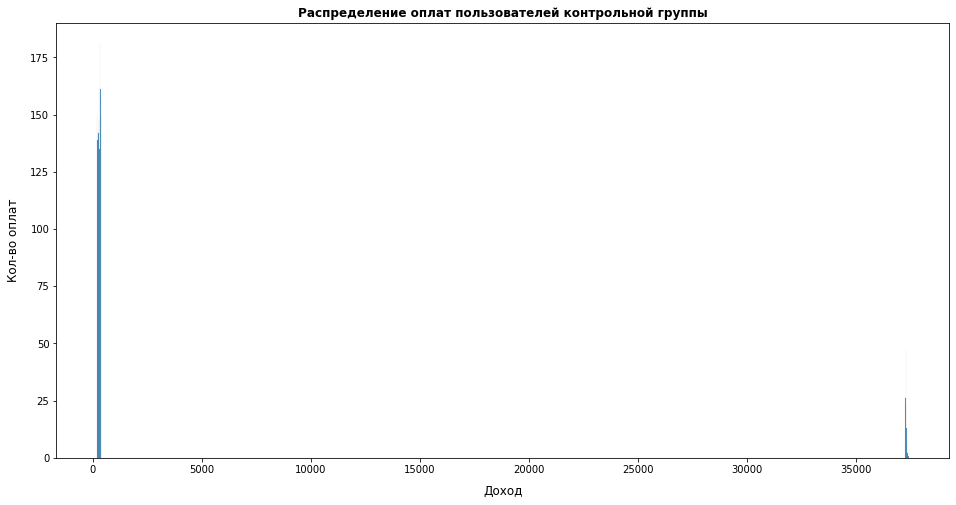

In [133]:
# посмотрим распределение оплат:
sns.histplot(control_pay.revenue)
plt.title("Распределение оплат пользователей контрольной группы",
          weight='bold', size=12)
plt.xlabel('Доход', labelpad=10, size=12)
plt.ylabel('Кол-во оплат', labelpad=10, size=12)

Text(0.5, 0, 'Доход')

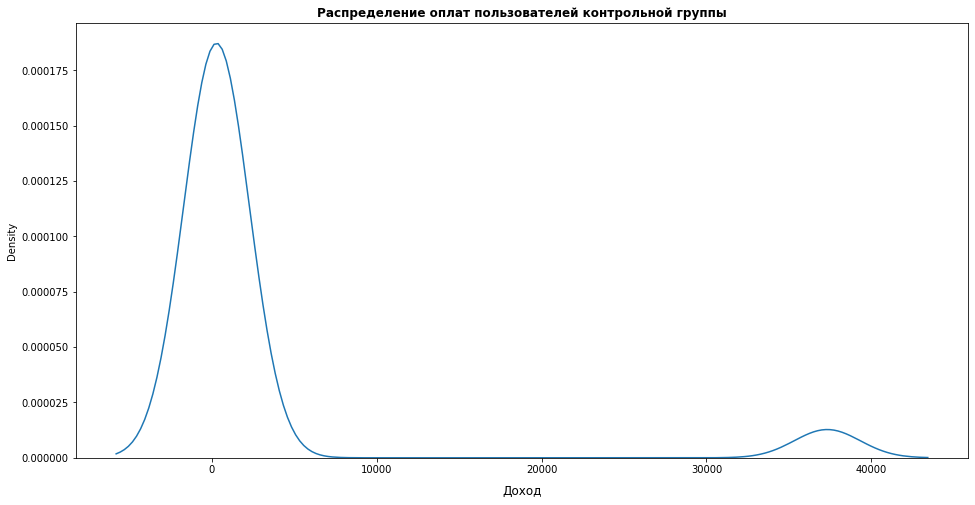

In [134]:
sns.kdeplot(control_pay.revenue) 
plt.title("Распределение оплат пользователей контрольной группы",
          weight='bold', size=12)
plt.xlabel('Доход', labelpad=10, size=12)

Мы видим, что большая часть покупок пользователей меньше чем `1000` , а остальная часть больше чем `35000`, проверим это:

In [135]:
control_pay[control_pay.revenue < 1000].revenue.max()

400

In [136]:
control_pay[control_pay.revenue > 1000].revenue.min()

37293

Отберем только платящих пользователей в контрольной группе которые заплатили больше 400:

In [137]:
control_pay_much = control_pay[control_pay.revenue > 400]
control_pay_much

user_id  revenue testgroup
416         417    37324         a
4428       4429    37304         a
5777       5778    37315         a
8065       8066    37307         a
8743       8744    37334         a
...         ...      ...       ...
360696   360697    37347         a
378668   378669    37297         a
389341   389342    37298         a
394580   394581    37302         a
399294   399295    37321         a

[123 rows x 3 columns]

Text(0, 0.5, 'Кол-во оплат')

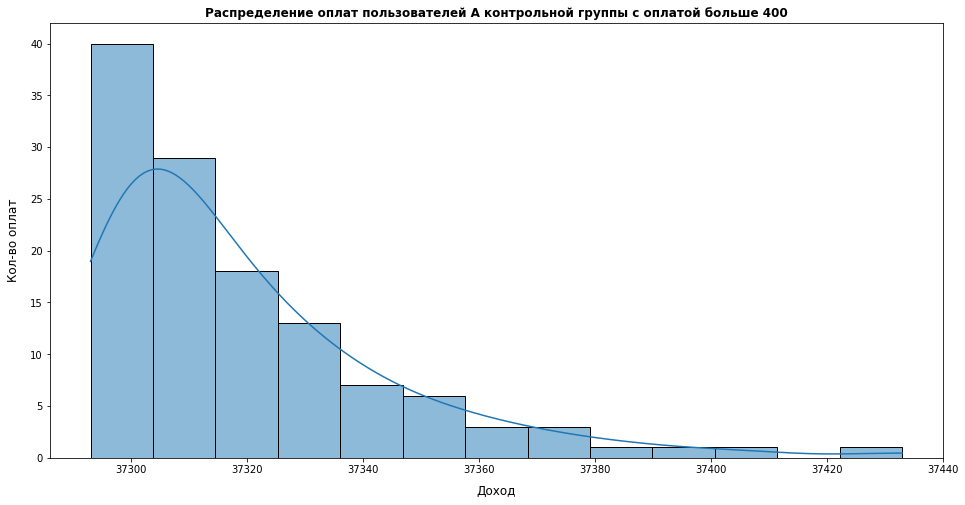

In [138]:
sns.histplot(control_pay_much.revenue, kde=True)
plt.title("Распределение оплат пользователей A контрольной группы с оплатой больше 400",
          weight='bold', size=12)
plt.xlabel('Доход', labelpad=10, size=12)
plt.ylabel('Кол-во оплат', labelpad=10, size=12)

И меньше 400:

In [139]:
control_pay_less = control_pay[control_pay.revenue <= 400]
control_pay_less

user_id  revenue testgroup
72           73      351         a
341         342      290         a
385         386      250         a
712         713      255         a
1346       1347      230         a
...         ...      ...       ...
404304   404305      360         a
404315   404316      262         a
404543   404544      369         a
404602   404603      251         a
404767   404768      231         a

[1805 rows x 3 columns]

Text(0, 0.5, 'Кол-во оплат')

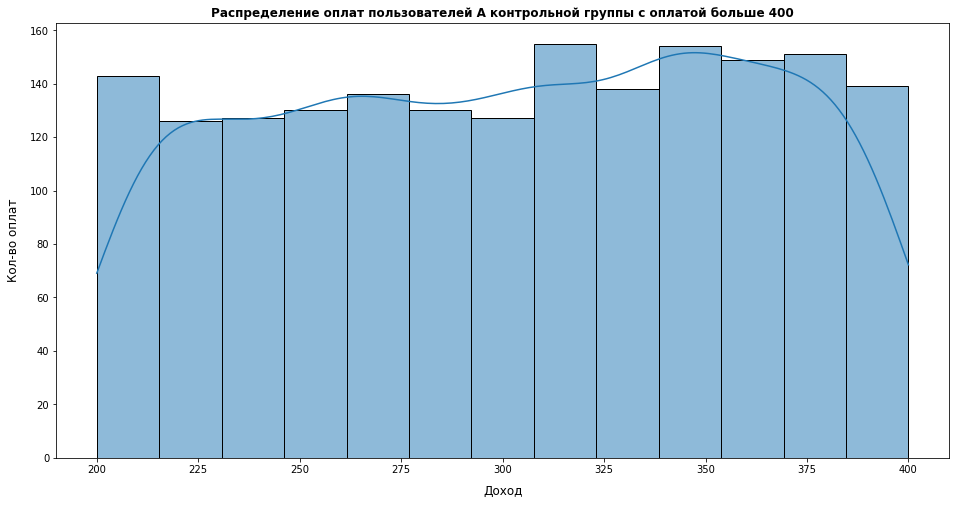

In [140]:
sns.histplot(control_pay_less.revenue, kde=True)
plt.title("Распределение оплат пользователей A контрольной группы с оплатой больше 400",
          weight='bold', size=12)
plt.xlabel('Доход', labelpad=10, size=12)
plt.ylabel('Кол-во оплат', labelpad=10, size=12)

**Выводы по анализу контрольной группы:**
* Пользователей контрольной группы в размере`1928` человек  можной разделить на два явных сегмента:
    1. с оплатой меньше `400` - обычные пользователи в количестве `1805` человек
    2. с оплатой больше `400` - либо технический сбой, либо пользователи, которые тратят в разы больше, чем основная группа пользователей, в количестве `123` человек

###  Анализ тестовой  группы

In [141]:
# отбираем пользователей тестовой группы:
test = df_2[df_2.testgroup == 'b']
test

user_id  revenue testgroup
0             1        0         b
3             4        0         b
4             5        0         b
5             6        0         b
6             7        0         b
...         ...      ...       ...
404761   404762        0         b
404763   404764        0         b
404764   404765        0         b
404766   404767        0         b
404769   404770        0         b

[202667 rows x 3 columns]

In [142]:
# посмотрим описательную статистику:
test.describe()

user_id        revenue
count  202667.000000  202667.000000
mean   202215.564389      26.751287
std    116891.926690     287.324162
min         1.000000       0.000000
25%    100855.500000       0.000000
50%    201821.000000       0.000000
75%    303602.500000       0.000000
max    404770.000000    4000.000000

In [143]:
# отбираем платящих пользователей тестовой группы:
test_pay = df_2_pay[df_2_pay.testgroup == 'b']
test_pay

user_id  revenue testgroup
160         161     3797         b
377         378     3768         b
386         387     3527         b
551         552     2038         b
913         914     3902         b
...         ...      ...       ...
403843   403844     3383         b
403994   403995     2793         b
404161   404162     2316         b
404193   404194     2998         b
404525   404526     3120         b

[1805 rows x 3 columns]

In [144]:
# посмотрим описательную статистику:
test_pay.describe()

user_id      revenue
count    1805.000000  1805.000000
mean   205834.548476  3003.658172
std    116400.045485   572.619709
min       161.000000  2000.000000
25%    106815.000000  2513.000000
50%    206651.000000  3022.000000
75%    304907.000000  3478.000000
max    404526.000000  4000.000000

Text(0, 0.5, 'Кол-во оплат')

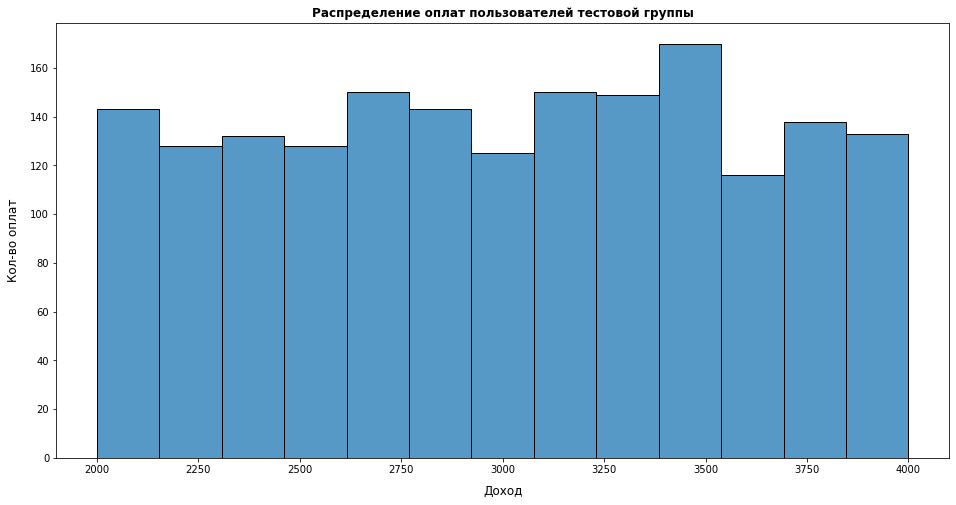

In [145]:
# посмотрим распределение оплат:
sns.histplot(test_pay.revenue)
plt.title("Распределение оплат пользователей тестовой группы",
          weight='bold', size=12)
plt.xlabel('Доход', labelpad=10, size=12)
plt.ylabel('Кол-во оплат', labelpad=10, size=12)

Text(0.5, 0, 'Доход')

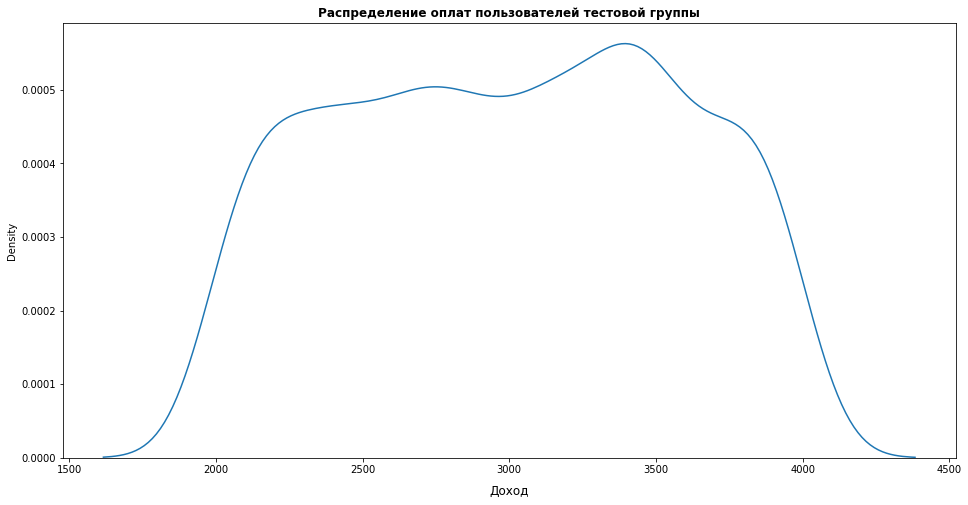

In [146]:
sns.kdeplot(test_pay.revenue) 
plt.title("Распределение оплат пользователей тестовой группы",
          weight='bold', size=12)
plt.xlabel('Доход', labelpad=10, size=12)

**Выводы по анализу B тестовой группы**
* Пользователей тестовой группы `1805` человек.
* Все пользователи относительно равномерно распределены в своих пределах, в отличии от контрольной группы.
* Размер тестовой группы совпадает с количеством обычных пользователей (<400).

### Проверка нормальности распределений

#### ARPU:

In [147]:
#  при помощи теста Шапиро-Уилка
shapiro(control.revenue.sample(4000))

ShapiroResult(statistic=0.02124953269958496, pvalue=0.0)

In [148]:
 shapiro(test.revenue.sample(4000))

ShapiroResult(statistic=0.053303301334381104, pvalue=0.0)

Считаем, что распределения не являются нормальным, так как pvalue < 0.05 в обоих группах.

In [149]:
# и с помощью ещё одного теста
ss.normaltest(control.revenue)

NormaltestResult(statistic=585152.7312728433, pvalue=0.0)

In [150]:
ss.normaltest(test.revenue)

NormaltestResult(statistic=326622.39540856465, pvalue=0.0)

Считаем, что распределения не являются нормальным, так как pvalue < 0.05 в обоих группах.

#### ARPPU:

In [151]:
#  при помощи теста Шапиро-Уилка
shapiro(control_pay.revenue.sample(1000))

ShapiroResult(statistic=0.26220184564590454, pvalue=0.0)

In [152]:
shapiro(test_pay.revenue.sample(1000))

ShapiroResult(statistic=0.951999843120575, pvalue=1.5171440383204513e-17)

In [153]:
# и с помощью ещё одного теста
ss.normaltest(control_pay.revenue)

NormaltestResult(statistic=1394.9457843086925, pvalue=1.2341605505935488e-303)

In [154]:
ss.normaltest(test_pay.revenue)

NormaltestResult(statistic=1068.8600084412267, pvalue=7.943249488371762e-233)

Считаем, что распределения не являются нормальным, так как pvalue < 0.05 в обоих группах.

#### Подготовка к статистическому анализу:

Создадим функцию bootstrap-анализа:

In [155]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

## Статистический анализ

#### ARPU

Так как распределения не являются нормальными, сравним величины непараметрическим тестом Манна-Уитни:

In [156]:
ss.mannwhitneyu(control.revenue, test.revenue)

MannwhitneyuResult(statistic=20491259376.0, pvalue=0.06269701316074398)

p-value >  0.05 , что не позволяет отклонить нулевую гипотезу об одинаковости распределений.

Выполним процедуру бутстрепа средних ARPU:

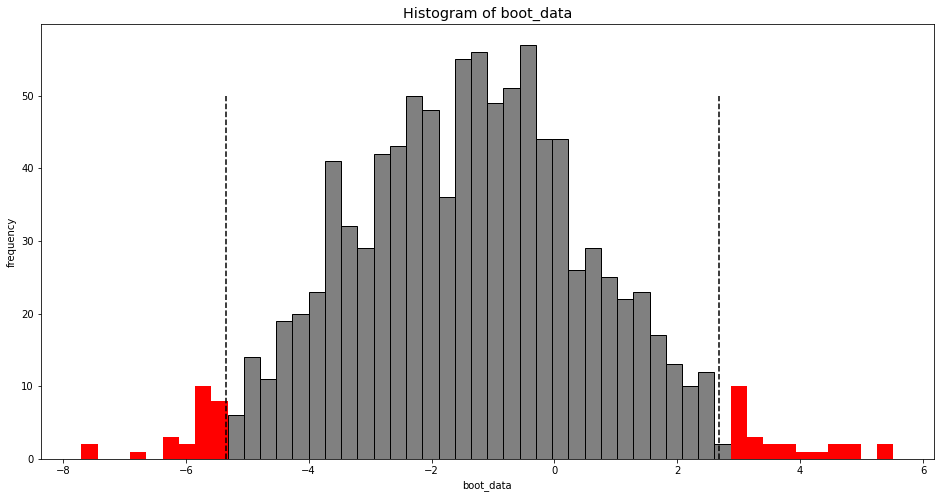

In [157]:
ARPU_bootstrap = get_bootstrap(control.revenue,
                               test.revenue)

In [158]:
# доверительные интервалы
ARPU_bootstrap['quants']

0
0.025 -5.348781
0.975  2.682686

In [159]:
# p-value
ARPU_bootstrap['p_value']

0.5077748497679738

p-value > 0.05, что не позволяет отклонить нулевую гипотезу о равенстве средних ARPU.

#### ARPPU
Так как распределения не являются нормальными, сравним величины непараметрическим тестом Манна-Уитни:

In [160]:
ss.mannwhitneyu(control_pay.revenue, test_pay.revenue)

MannwhitneyuResult(statistic=222015.0, pvalue=0.0)

p-value < 0.05, что позволяет отбросить гипотезу об одинаковости распределений. Контрольная группа статистически значимо отличается от тестовой.

Выполним процедуру бутстрепа средних ARPPU:

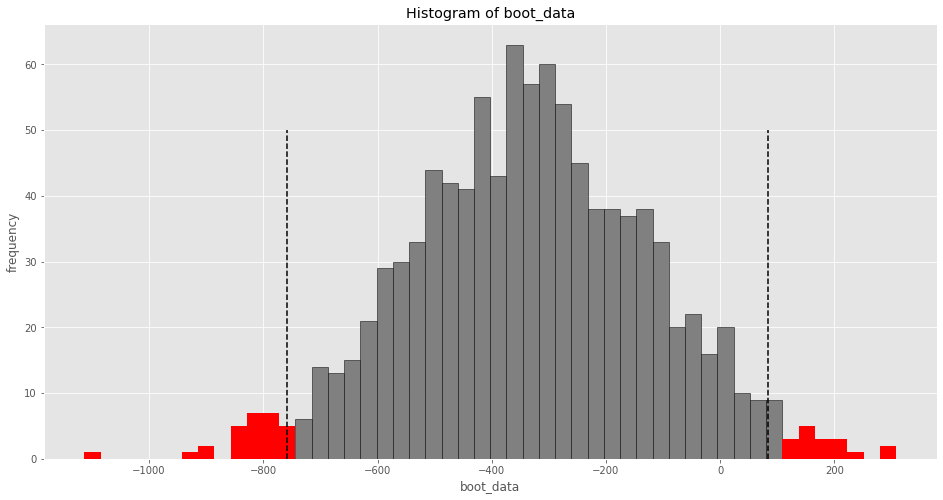

In [161]:
ARPPU_bootstrap = get_bootstrap(control_pay.revenue,
                               test_pay.revenue)

In [162]:
# доверительные интервалы
ARPPU_bootstrap['quants']

0
0.025 -759.318906
0.975   83.628281

In [163]:
# p-value
ARPPU_bootstrap['p_value']

0.11330979439210166

p-value > 0.05, что не позволяет отбросить нулевую гипотезу о равенстве средних ARPPU. Однако, вспоминаем, что в группе платящих было 123 значения с выбросами, что могло повлиять негативно на бутстреп средних ARPPU.

Проверим это и выполним процедуру бутстрепа медианных ARPPU:

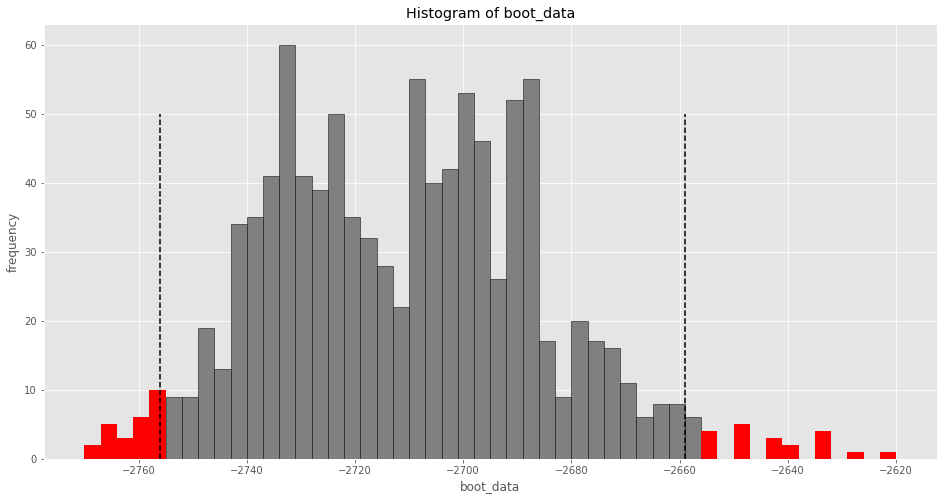

In [164]:
ARPPU_median_bootstrap = get_bootstrap (control_pay.revenue,
                                        test_pay.revenue,
                                        statistic = np.median)

In [165]:
# доверительные интервалоы
ARPPU_median_bootstrap['quants']

0
0.025 -2756.0000
0.975 -2658.9875

In [166]:
# p-value
ARPPU_median_bootstrap['p_value']

0.0

p-value < 0.05, что позволяет отбросить нулевую гипотезу о равенстве медианных ARPPU. Контрольная группа статистически значимо отличается от тестовой.

## CR

**CR (конверсия в оплату)** по группам является категориальной переменнной:
 * **YES** - Пользователь оплатил 
 * **NO** - Пользователь не оплатил 
 
 Поэтому стоит использовать метод XИ - квадрат.
 
 Также χ²-тесты применимы к анализу воронок, что как раз и является нашим случаем

In [167]:
chi_2 = df_2

In [168]:
chi_2['pay']= np.where(chi_2['revenue'] > 0, 'yes', 'no')
chi_2 

user_id  revenue testgroup  pay
0             1        0         b   no
1             2        0         a   no
2             3        0         a   no
3             4        0         b   no
4             5        0         b   no
...         ...      ...       ...  ...
404765   404766        0         a   no
404766   404767        0         b   no
404767   404768      231         a  yes
404768   404769        0         a   no
404769   404770        0         b   no

[404770 rows x 4 columns]

**Создадим кросс-таблицу по датафрейму с отдельной колонкой по платящим пользователям**

In [169]:
chi_2_cross = pd.crosstab(chi_2['pay'], chi_2['testgroup'])
chi_2_cross

testgroup       a       b
pay                      
no         200175  200862
yes          1928    1805

In [170]:
# подсчитаем статистику
chi, p, dof, expected  = ss.chi2_contingency(chi_2_cross)

In [171]:
# статистика chi2
chi

4.374729521260405

In [172]:
# p-value
p

0.03647561892312613

In [173]:
# степени свободы
dof

1

Сравним значение статистики chi2 с пороговым значением:

In [174]:
probability = 0.95

In [175]:
ss.chi2.ppf(probability, dof)

3.841458820694124

p-value < 0.05 и значение статистики chi2 больше порогового значения, что позволяет говорить о статистически значимом различии между значениями CR

## Выводы
* **Распределения значений тестовой и контрольной группы отличаются. Контрольная группа имеет выбросы;**

* **ARPU не показал статистического значимого прироста у тестовой группы по сравнению с контрольной;**

* **ARPPU показал статистически значимый прирост на `12,75 %` у тестовой группы по сравнению с контрольной;**

* **CR показал статистически значимое падение на `6.64 %` у тестовой группы по сравнению с контрольной;**
     * В контрольной группе есть явно вырыженные выбросы. Нужно разобраться, это реальные значения, которые приносят нам значительную часть выручки, в случае чего стоит проводить A/B тест с учетом RFM-сегментации пользователей; 
     * В противном случае, нужно проверить на данных A/A теста систему сплитования**
* **Так как метрики показали неоднозначные показатели (что-то улучшилось, что-то ухудшилось, а что-то не поменялось), рекомендуется `не принимать изменения`** 

**Вопросы на уточнение:** 
*  Исходная таблица сгруппирована по пользователям, поэтому нет возможности проверить:
    * долю новых и старых пользователей в группах;
    * период анализа данных;
    
##### Исходя из этого рекомендуется откатиться к контрольному варианту и провести повторный A/B-тест с учётом проведения A/A-теста для искоренения ошибок в выборе групп.